In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [2]:
gend_df = pd.read_csv('../data/gender_submission.csv')
test_df = pd.read_csv('../data/test.csv')
train_df = pd.read_csv('../data/train.csv')

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Running Random Forest Model on variables

X = train_df.loc[:,['Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']]
y = train_df.loc[:,'Survived']
X_encoded = pd.get_dummies(X)
X_train, X_test, y_train, y_test  = train_test_split(X_encoded,y,random_state=10,test_size=0.2)
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
rf.score(X_test,y_test)
print("The accuracy score is " + str(rf.score(X_test,y_test)))

The accuracy score is 0.8435754189944135


In [5]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       117
           1       0.78      0.76      0.77        62

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



In [6]:
# Create DataFrame with feature names
features = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

features[0:15]

,feature,importance
1,Age,0.222811
4,Fare,0.210057
6,Sex_male,0.123972
5,Sex_female,0.123405
0,Pclass,0.077266
2,SibSp,0.051181
3,Parch,0.039173
156,Embarked_S,0.015511
154,Embarked_C,0.012752
155,Embarked_Q,0.007002


Important features: age, fare, sex, Pclass, SibSp, Parch and Embarked

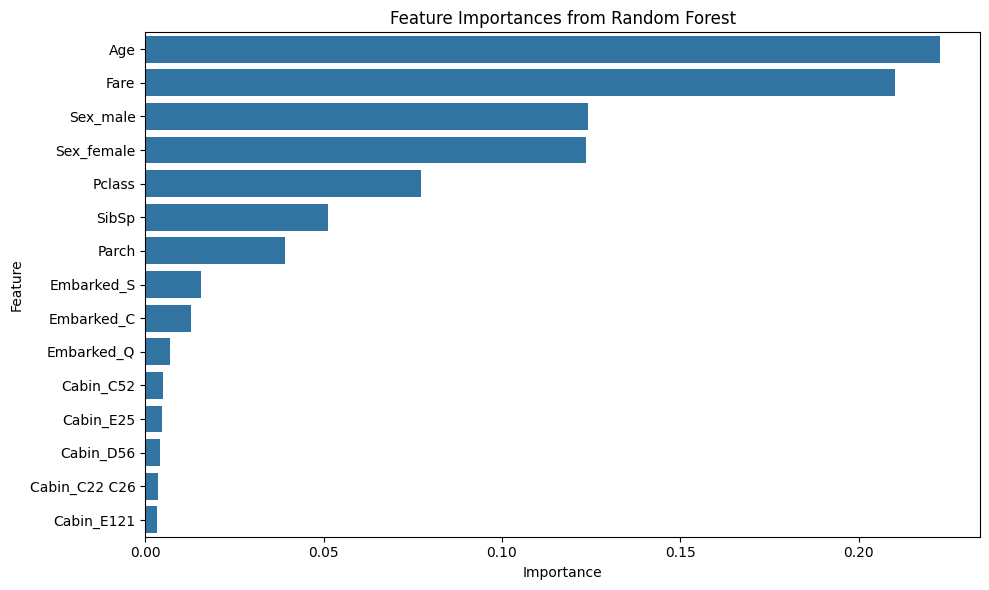

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot
top_features = features[0:15]
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

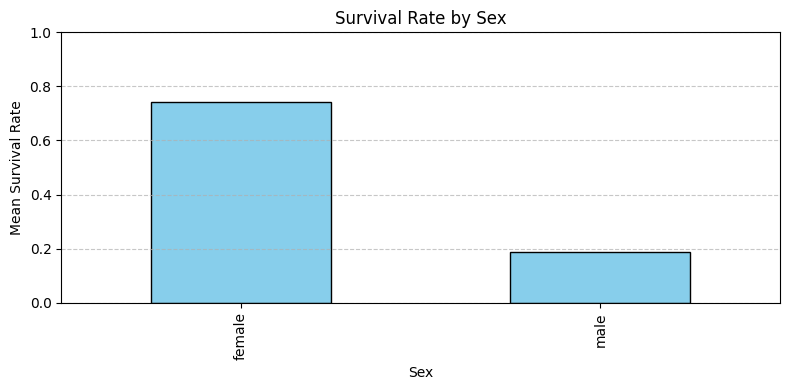

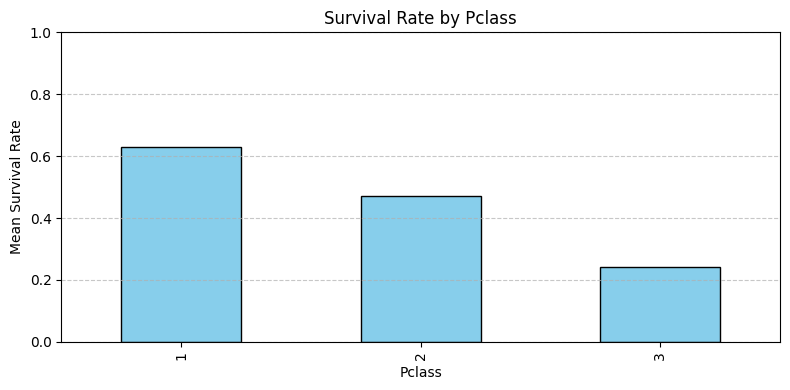

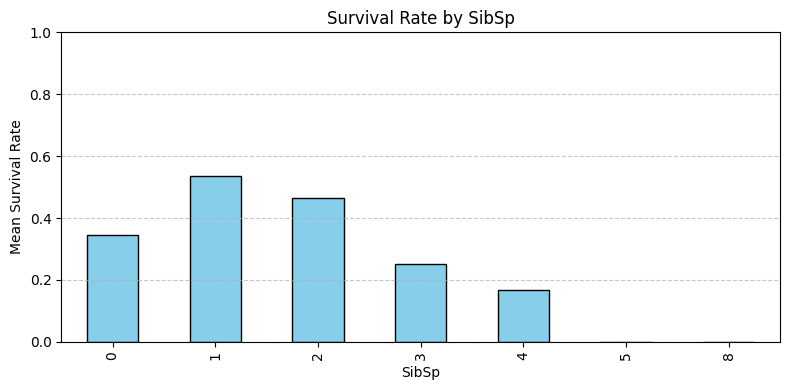

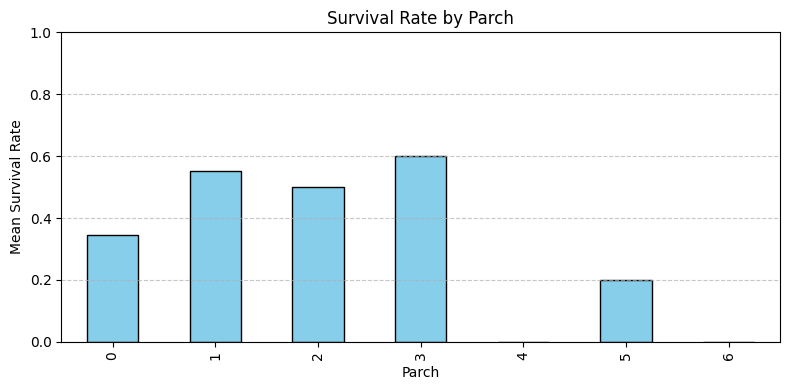

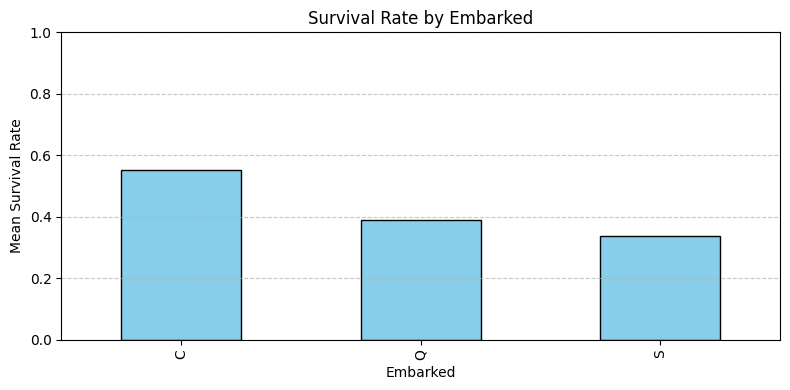

In [8]:
# Loop through all features except 'Survived'
for col in train_df.loc[:,['Sex','Pclass','SibSp','Parch','Embarked','Survived']].columns:
    if col == 'Survived':
        continue

    plt.figure(figsize=(8, 4))
    # Group by feature value and compute mean survival rate
    survival_rate = train_df.groupby(col)['Survived'].mean()

    # Plot bar chart
    survival_rate.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Survival Rate by {col}")
    plt.ylabel("Mean Survival Rate")
    plt.xlabel(col)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

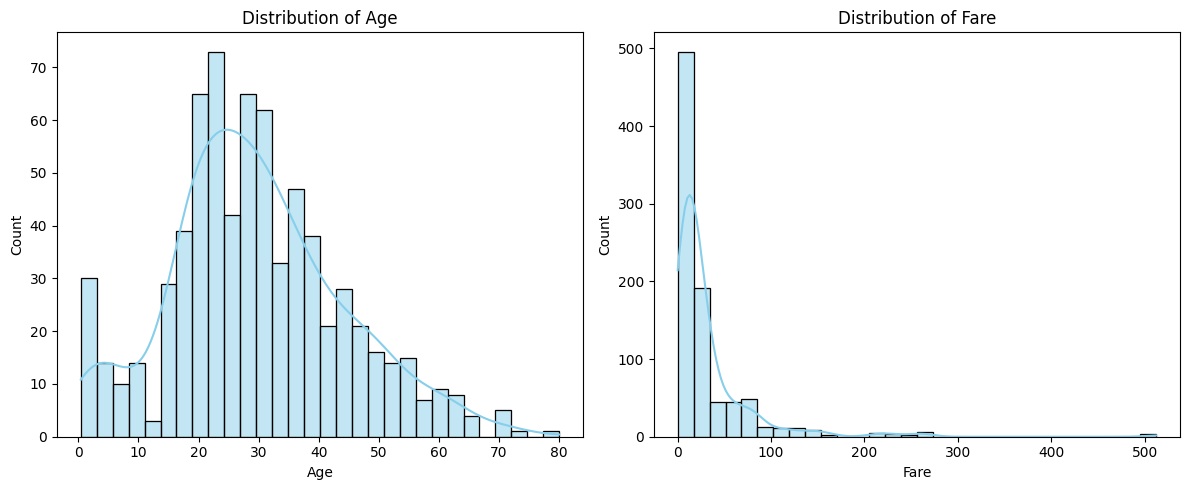

In [9]:
# Plot histograms for Age and Fare
cols = ['Age', 'Fare']
df_subset = train_df.loc[:, cols]

plt.figure(figsize=(12, 5))

for i, col in enumerate(cols, 1):
    plt.subplot(1, 2, i)
    sns.histplot(df_subset[col].dropna(), kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

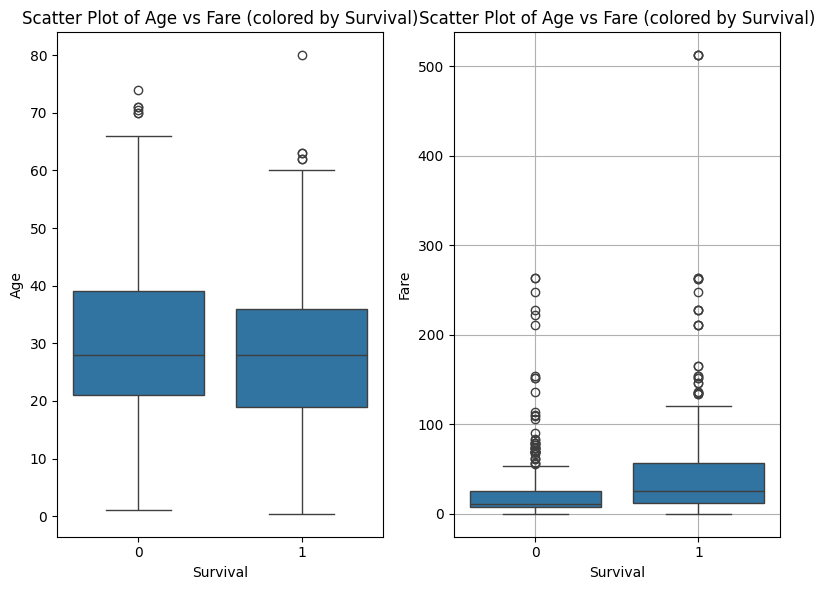

In [10]:
plt.figure(figsize=(8, 6))
plt.subplot(1, 2,1)
sns.boxplot(data=train_df, x='Survived', y='Age')  # or 'Fare'
plt.title('Scatter Plot of Age vs Fare (colored by Survival)')
plt.xlabel('Survival')
plt.ylabel('Age')

plt.subplot(1, 2,2)
sns.boxplot(data=train_df, x='Survived', y='Fare')  # or 'Fare'
plt.title('Scatter Plot of Age vs Fare (colored by Survival)')
plt.xlabel('Survival')
plt.ylabel('Fare')

plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# now optimizing the hyperparameters

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [None] + list(range(10, 50, 10)),
    'min_samples_split': randint(2, 10),
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_dist,
                                   n_iter=20,
                                   cv=5,
                                   scoring='accuracy',
                                   n_jobs=-1,
                                   random_state=42,
                                   verbose=1)

random_search.fit(X_encoded, y)
print("Best params from random search:", random_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params from random search: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 187}


In [12]:
best_rf = random_search.best_estimator_

# You can now use it directly to predict
y_pred = best_rf.predict(X_test)
best_rf.score(X_test,y_test)

0.9720670391061452

In [13]:
best_rf = random_search.best_estimator_

# You can now use it directly to predict
y_pred = best_rf.predict(X_test)
best_rf.score(X_test,y_test)
print("With optimized hyperparameters, the accuracy score of the RandomForest model is: " + str(best_rf.score(X_test,y_test)))
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

With optimized hyperparameters, the accuracy score of the RandomForest model is: 0.9720670391061452
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       117
           1       0.98      0.94      0.96        62

    accuracy                           0.97       179
   macro avg       0.97      0.96      0.97       179
weighted avg       0.97      0.97      0.97       179



In [15]:
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
X_test = pd.get_dummies(test_df[features]).fillna(False)
X = pd.get_dummies(train_df[features]).fillna(False)
y = train_df["Survived"]
model = RandomForestClassifier(n_estimators=263, max_depth=20, random_state=1, max_features= 'log2', min_samples_split =  2 )
model.fit(X, y)
predictions = model.predict(X_test)


output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('../submission/submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
